In [3]:
import sys
from pathlib import Path

print("🔧 SETTING UP PROJECT PATHS")
print("=" * 30)

current_dir = Path.cwd()
print(f"Current directory: {current_dir}")

# Adding current_dir.parent to Python path (which contains churn_analysis)
project_root = current_dir.parent
src_path = project_root

print(f"Project root (src folder): {project_root}")
print(f"Adding to Python path: {src_path}")

# Adding the src folder (project_root) to Python path
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))
    print(f"✅ Added to Python path: {src_path}")

# Verifying churn_analysis module is accessible
churn_analysis_path = src_path / 'churn_analysis'
print(f"Looking for churn_analysis at: {churn_analysis_path}")
print(f"churn_analysis exists: {churn_analysis_path.exists()}")

# Checking config folder
config_path = churn_analysis_path / 'config'
print(f"Config folder exists: {config_path.exists()}")

# Trying to import
try:
    from churn_analysis.config.settings import TELCO_RAW_FILE, FIGURE_SIZE, RANDOM_STATE
    print("✅ Successfully imported settings!")
    
    # Testing the settings
    print(f"Data file path: {TELCO_RAW_FILE}")
    print(f"Data file exists: {TELCO_RAW_FILE.exists()}")
    
except ImportError as e:
    print(f"❌ Import failed: {e}")
    
    # Debugging the config folder contents
    if config_path.exists():
        print(f"Files in config folder:")
        for file in config_path.iterdir():
            print(f"  📄 {file.name}")

# Standard libraries
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from rich import print
import pyarrow as pa

# Notebook setup
try:
    plt.style.use('seaborn-v0_8')
    plt.rcParams['figure.figsize'] = FIGURE_SIZE
    sns.set_palette("husl")
    print("✅ Visualization settings applied")
except:
    # Fallback if settings import failed
    plt.rcParams['figure.figsize'] = (12, 8)
    print("⚠️ Using fallback visualization settings")

🔧 SETTING UP PROJECT PATHS
Current directory: C:\Users\joaqu\Desktop\code\ML\churn-prediction-project\src\notebooks
Project root (src folder): C:\Users\joaqu\Desktop\code\ML\churn-prediction-project\src
Adding to Python path: C:\Users\joaqu\Desktop\code\ML\churn-prediction-project\src
✅ Added to Python path: C:\Users\joaqu\Desktop\code\ML\churn-prediction-project\src
Looking for churn_analysis at: C:\Users\joaqu\Desktop\code\ML\churn-prediction-project\src\churn_analysis
churn_analysis exists: True
Config folder exists: True
✅ Successfully imported settings!
Data file path: C:\Users\joaqu\Desktop\code\ML\churn-prediction-project\src\data\raw\WA_Fn-UseC_-Telco-Customer-Churn.csv
Data file exists: True


✅ Visualization settings applied

In [16]:
# Cell 2: Load and initial inspection
from data.loaders.loaders import load_telco_data, get_dataset_info
from churn_analysis.visualization.display_utils import create_rich_table, display_insights_summary, display_business_alert

print("🔍 Loading Telco Customer Churn Dataset...")
df= load_telco_data()

info= get_dataset_info(df)
print(f"📊 Dataset Info: {info}")

🔍 Loading Telco Customer Churn Dataset...

✅ Dataset loaded: 7043 rows, 21 columns


📊 Dataset Info: {'shape': (7043, 21), 'columns': ['customerID', 'gender', 'SeniorCitizen', 'Partner', 
'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 
'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'], 'null_count': 11, 'dtypes': {'customerID': 'String', 
'gender': 'String', 'SeniorCitizen': 'Int64', 'Partner': 'String', 'Dependents': 'String', 'tenure': 'Int64', 
'PhoneService': 'String', 'MultipleLines': 'String', 'InternetService': 'String', 'OnlineSecurity': 'String', 
'OnlineBackup': 'String', 'DeviceProtection': 'String', 'TechSupport': 'String', 'StreamingTV': 'String', 
'StreamingMovies': 'String', 'Contract': 'String', 'PaperlessBilling': 'String', 'PaymentMethod': 'String', 
'MonthlyCharges': 'Float64', 'TotalCharges': 'Float64', 'Churn': 'String'}}

🎯 TARGET VARIABLE ANALYSIS (CHURN RATE)

========================================

Comprehensive Churn Analysis:

shape: (2, 3)
┌───────┬───────┬────────────┐
│ Churn ┆ count ┆ percentage │
│ ---   ┆ ---   ┆ ---        │
│ str   ┆ u32   ┆ f64        │
╞═══════╪═══════╪════════════╡
│ No    ┆ 5174  ┆ 73.463013  │
│ Yes   ┆ 1869  ┆ 26.536987  │
└───────┴───────┴────────────┘

📊 KEY METRICS:

Total Customers: 7,043

Churned Customers: 1,869

Retention Rate: 73.5%

🚨 CHURN RATE: 26.5%

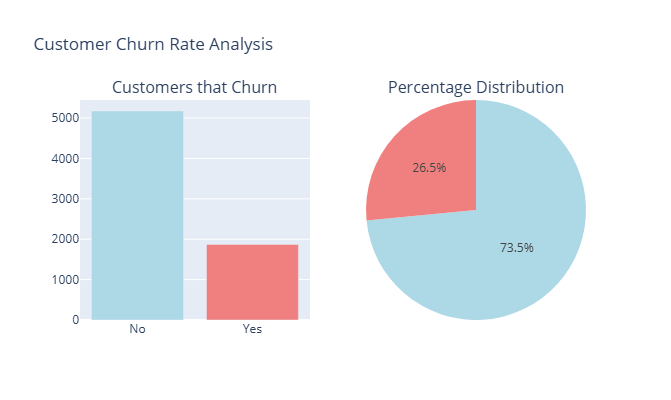

In [5]:
# Cell 3: Target Variable Analysis - Churn Rate
print("🎯 TARGET VARIABLE ANALYSIS (CHURN RATE)")
print("=" * 40)

churn_analysis = df.select([
    pl.col("Churn").value_counts().alias("distribution")
]).unnest("distribution").with_columns([
    (pl.col("count") / pl.col("count").sum() * 100).alias("percentage")
]).sort("Churn")

print("Comprehensive Churn Analysis:")
print(churn_analysis)

# Extracting key metrics
total_customers = df.height
churned_customers = df.filter(pl.col("Churn") == "Yes").height
churn_rate = (churned_customers / total_customers) * 100

print(f"\n📊 KEY METRICS:")
print(f"   Total Customers: {total_customers:,}")
print(f"   Churned Customers: {churned_customers:,}")
print(f"   Retention Rate: {100 - churn_rate:.1f}%")
print(f"   🚨 CHURN RATE: {churn_rate:.1f}%")

# Visualization with plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Converting to pandas for easier plotting
churn_data = churn_analysis.to_pandas()

# Creating subplots
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Customers that Churn', 'Percentage Distribution'),
    specs=[[{"type": "bar"}, {"type": "pie"}]]
)

# Bar chart
fig.add_trace(
    go.Bar(
        x=churn_data["Churn"],
        y=churn_data["count"],
        marker_color=['lightblue', 'lightcoral'],
        name="Count"
    ),
    row=1, col=1
)

# Pie chart
fig.add_trace(
    go.Pie(
        labels=churn_data["Churn"],
        values=churn_data["percentage"],
        marker_colors=['lightblue', 'lightcoral'],
        name="Percentage"
    ),
    row=1, col=2
)

fig.update_layout(
    title_text="Customer Churn Rate Analysis",
    height=400,
    showlegend=False
)

fig.show()

In [20]:
print("💰 FINANCIAL IMPACT OF CUSTUMER CHURN")
print("=" * 40)

#Revenue Analysis:
revenue_analysis= df.group_by("Churn").agg([
    pl.col("customerID").count().alias("Customer_count"),
    pl.col("MonthlyCharges").mean().alias("Avg_Monthly_Revenue"),
    pl.col("MonthlyCharges").sum().alias("Total_Monthly_Revenue"),
    pl.col("TotalCharges").mean().alias("Avg_Lifetime_Value"),
    pl.col("TotalCharges").sum().alias("Total_Lifetime_Revenue"),
    pl.col("tenure").mean().alias("Avg_Tenure_Months")
])

print("💳 Revenue Analysis by Churn Status:")
print(revenue_analysis)

#Calculating finantial impacts:
churned_revenue= revenue_analysis.filter(pl.col("Churn") == "Yes")
retained_revenue= revenue_analysis.filter(pl.col("Churn") == "No")

#Extracting values for calculations:
churned_monthly= churned_revenue["Total_Monthly_Revenue"][0]
churned_avg_monthly= churned_revenue["Avg_Monthly_Revenue"][0]
churned_avg_lifetime= churned_revenue["Avg_Lifetime_Value"][0]

retained_monthly= retained_revenue["Total_Monthly_Revenue"][0]
retained_avg_monthly= retained_revenue["Avg_Monthly_Revenue"][0]
retained_avg_lifetime= retained_revenue["Avg_Lifetime_Value"][0]

#Calculating annual impact:
monthly_revenue_lost= churned_monthly
annual_revenue_lost= monthly_revenue_lost * 12

print(f"\n🚨 FINANCIAL IMPACT SUMMARY:")
print(f"   Monthly Revenue Lost: ${monthly_revenue_lost:,.0f}")
print(f"   Annual Revenue Lost: ${annual_revenue_lost:,.0f}")
print(f"   Average Monthly Value per Churned Customer: ${churned_avg_monthly:.2f}")
print(f"   Average Lifetime Value Lost per Churned Customer: ${churned_avg_lifetime:.2f}")

# Customer acquisition cost perspective
total_lifetime_lost = churned_revenue["Total_Lifetime_Revenue"][0]
print(f"   Total Customer Lifetime Value Lost: ${total_lifetime_lost:,.0f}")


💰 FINANCIAL IMPACT OF CUSTUMER CHURN

========================================

💳 Revenue Analysis by Churn Status:

shape: (2, 7)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ Chu ┆ Cus ┆ Avg ┆ Tot ┆ Avg ┆ Tot ┆ Avg │
│ rn  ┆ tom ┆ _Mo ┆ al_ ┆ _Li ┆ al_ ┆ _Te │
│ --- ┆ er_ ┆ nth ┆ Mon ┆ fet ┆ Lif ┆ nur │
│ str ┆ cou ┆ ly_ ┆ thl ┆ ime ┆ eti ┆ e_M │
│     ┆ nt  ┆ Rev ┆ y_R ┆ _Va ┆ me_ ┆ ont │
│     ┆ --- ┆ enu ┆ eve ┆ lue ┆ Rev ┆ hs  │
│     ┆ u32 ┆ e   ┆ nue ┆ --- ┆ enu ┆ --- │
│     ┆     ┆ --- ┆ --- ┆ f64 ┆ e   ┆ f64 │
│     ┆     ┆ f64 ┆ f64 ┆     ┆ --- ┆     │
│     ┆     ┆     ┆     ┆     ┆ f64 ┆     │
╞═════╪═════╪═════╪═════╪═════╪═════╪═════╡
│ Yes ┆ 186 ┆ 74. ┆ 139 ┆ 153 ┆ 2.8 ┆ 17. │
│     ┆ 9   ┆ 441 ┆ 130 ┆ 1.7 ┆ 629 ┆ 979 │
│     ┆     ┆ 332 ┆ .85 ┆ 960 ┆ e6  ┆ 133 │
│     ┆     ┆     ┆     ┆ 94  ┆     ┆     │
│ No  ┆ 517 ┆ 61. ┆ 316 ┆ 255 ┆ 1.3 ┆ 37. │
│     ┆ 4   ┆ 265 ┆ 985 ┆ 5.3 ┆ 193 ┆ 569 │
│     ┆     ┆ 124 ┆ .75 ┆ 441 ┆ e7  ┆ 965 │
│     ┆     ┆     ┆     ┆ 41  ┆     ┆     │
└─────┴─────┴─────┴─────┴─────┴─────┴─────┘

🚨 FINANCIAL IMPACT SUMMARY:

Monthly Revenue Lost: $139,131

Annual Revenue Lost: $1,669,570

Average Monthly Value per Churned Customer: $74.44

Average Lifetime Value Lost per Churned Customer: $1531.80

Total Customer Lifetime Value Lost: $2,862,927

In [30]:
# Revenue Risk by Customer Segment:
print("📊 REVENUE RISK BY CUSTOMER SEGMENTS")
print("=" * 40)

# Defining customer value segments based on monthly charges:
df_with_segments = df.with_columns([
    pl.when(pl.col("MonthlyCharges") >= 80)
    .then(pl.lit("High Value (+$80)"))
    .when(pl.col("MonthlyCharges") >= 50)
    .then(pl.lit("Medium Value ($50-79)"))
    .when(pl.col("MonthlyCharges") >= 30)
    .then(pl.lit("Low-Medium Value ($30-49)"))
    .otherwise(pl.lit("Low Value (<$30)"))
    .alias("Value_Segment")
])

# Analyzing churn and revenue by value segments:
segment_analysis = df_with_segments.group_by(["Value_Segment", "Churn"]).agg([
    pl.col("customerID").count().alias("Customer_Count"),
    pl.col("MonthlyCharges").sum().alias("Monthly_Revenue"),
    pl.col("MonthlyCharges").mean().alias("Avg_Monthly_Charge")
]).sort("Value_Segment")

print("Revenue Analysis by Customer Value Segment:")
print(segment_analysis)

# 📊 READABLE INSIGHTS FROM SEGMENT ANALYSIS
print("\n" + "🔍 KEY INSIGHTS FROM SEGMENT ANALYSIS:")
print("-" * 45)

segment_totals = df_with_segments.group_by("Value_Segment").agg([
    pl.col("customerID").count().alias("total"),
    (pl.col("Churn") == "Yes").sum().alias("churned")
]).with_columns([
    (pl.col("churned") / pl.col("total") * 100).alias("churn_rate")
])

for row in segment_totals.iter_rows(named=True):
    segment = row["Value_Segment"]
    total = row["total"]
    churned = row["churned"]
    churn_rate = row["churn_rate"]
    
    print(f"📈 {segment}:")
    print(f"   └── Total customers: {total:,}")
    print(f"   └── Churned: {churned:,} ({churn_rate:.1f}%)")
    print()

# Calculating churn rate and revenue impact by segment:
segment_summary = df_with_segments.group_by("Value_Segment").agg([
    pl.col("customerID").count().alias("Total_Customers"),
    (pl.col("Churn") == "Yes").sum().alias("Churned_Customers"),
    pl.col("MonthlyCharges").sum().alias("Total_Monthly_Revenue"),
    pl.col("MonthlyCharges").mean().alias("Avg_Monthly_Charges")
]).with_columns([
    (pl.col("Churned_Customers") / pl.col("Total_Customers") * 100).alias("Churn_Rate"),
    (pl.col("Churned_Customers") * pl.col("Avg_Monthly_Charges") * 12).alias("Annual_Revenue_At_Risk")
]).sort("Avg_Monthly_Charges", descending=True)

print(f"\n💰 Revenue Risk Summary by Segment:")
print(segment_summary)

# 💰 READABLE FINANCIAL INSIGHTS
print("\n" + "💰 FINANCIAL IMPACT INSIGHTS:")
print("-" * 45)

total_revenue_at_risk = segment_summary["Annual_Revenue_At_Risk"].sum()
highest_value_segment = segment_summary.filter(pl.col("Avg_Monthly_Charges") == pl.col("Avg_Monthly_Charges").max())
highest_risk_segment = segment_summary.filter(pl.col("Churn_Rate") == pl.col("Churn_Rate").max())

print(f"🚨 TOTAL ANNUAL REVENUE AT RISK: ${total_revenue_at_risk:,.0f}")
print()

for row in segment_summary.iter_rows(named=True):
    segment = row["Value_Segment"]
    customers = row["Total_Customers"]
    churned = row["Churned_Customers"]
    churn_rate = row["Churn_Rate"]
    avg_monthly = row["Avg_Monthly_Charges"]
    annual_risk = row["Annual_Revenue_At_Risk"]
    
    risk_level = "🔴 HIGH" if churn_rate > 30 else "🟡 MEDIUM" if churn_rate > 20 else "🟢 LOW"
    
    print(f"💎 {segment} Segment:")
    print(f"   ├── Risk Level: {risk_level} RISK ({churn_rate:.1f}% churn)")
    print(f"   ├── Customer Base: {customers:,} customers")
    print(f"   ├── Average Monthly Value: ${avg_monthly:.2f}")
    print(f"   ├── Customers Lost: {churned:,}")
    print(f"   └── Annual Revenue at Risk: ${annual_risk:,.0f}")
    print()

# Key business insights
highest_value_name = highest_value_segment["Value_Segment"][0]
highest_value_churn = highest_value_segment["Churn_Rate"][0]
highest_risk_name = highest_risk_segment["Value_Segment"][0]
highest_risk_rate = highest_risk_segment["Churn_Rate"][0]

print("🎯 STRATEGIC INSIGHTS:")
print(f"   ⭐ Most Valuable Segment: {highest_value_name}")
print(f"      └── Churn Rate: {highest_value_churn:.1f}% {'(GOOD)' if highest_value_churn < 25 else '(NEEDS ATTENTION)'}")
print(f"   ⚠️  Highest Risk Segment: {highest_risk_name} ({highest_risk_rate:.1f}% churn)")

# Finding the highest risk segment:
high_risk_revenue = segment_summary.filter(pl.col("Churn_Rate") > 25).sort("Annual_Revenue_At_Risk", descending=True)
print(f"\n🚨 Highest Revenue Risk Segments (+25% churn):")
print(high_risk_revenue.select(["Value_Segment", "Churn_Rate", "Annual_Revenue_At_Risk"]))

# 🚨 CRITICAL BUSINESS ALERTS
print("\n" + "🚨 CRITICAL BUSINESS ALERTS:")
print("-" * 45)

critical_segments = high_risk_revenue.iter_rows(named=True)
for i, row in enumerate(critical_segments, 1):
    segment = row["Value_Segment"]
    churn_rate = row["Churn_Rate"]
    revenue_risk = row["Annual_Revenue_At_Risk"]
    
    print(f"⚠️  ALERT #{i}: {segment}")
    print(f"   ├── Churn Rate: {churn_rate:.1f}% (ABOVE 25% THRESHOLD)")
    print(f"   ├── Revenue at Risk: ${revenue_risk:,.0f} annually")
    print(f"   └── Recommended Action: IMMEDIATE RETENTION STRATEGY")
    print()

# Calculate potential impact of improvements
if len(list(critical_segments)) > 0:
    total_critical_risk = high_risk_revenue["Annual_Revenue_At_Risk"].sum()
    potential_savings_25_percent = total_critical_risk * 0.25
    potential_savings_50_percent = total_critical_risk * 0.50
    
    print("💡 OPPORTUNITY ANALYSIS:")
    print(f"   🎯 25% Churn Reduction in High-Risk Segments: ${potential_savings_25_percent:,.0f} savings")
    print(f"   🎯 50% Churn Reduction in High-Risk Segments: ${potential_savings_50_percent:,.0f} savings")
    print(f"   📊 Total High-Risk Revenue: ${total_critical_risk:,.0f}")
else:
    print("✅ GOOD NEWS: No segments exceed 25% churn threshold!")

print("\n" + "="*60)

📊 REVENUE RISK BY CUSTOMER SEGMENTS

========================================

Revenue Analysis by Customer Value Segment:

shape: (8, 5)
┌───────────────────────────┬───────┬────────────────┬─────────────────┬────────────────────┐
│ Value_Segment             ┆ Churn ┆ Customer_Count ┆ Monthly_Revenue ┆ Avg_Monthly_Charge │
│ ---                       ┆ ---   ┆ ---            ┆ ---             ┆ ---                │
│ str                       ┆ str   ┆ u32            ┆ f64             ┆ f64                │
╞═══════════════════════════╪═══════╪════════════════╪═════════════════╪════════════════════╡
│ High Value (+$80)         ┆ Yes   ┆ 910            ┆ 85669.35        ┆ 94.142143          │
│ High Value (+$80)         ┆ No    ┆ 1767           ┆ 169611.5        ┆ 95.988398          │
│ Low Value (<$30)          ┆ Yes   ┆ 162            ┆ 3583.75         ┆ 22.121914          │
│ Low Value (<$30)          ┆ No    ┆ 1491           ┆ 31961.6         ┆ 21.436351          │
│ Low-Medium Value ($30-49) ┆ Yes   ┆ 199            ┆ 8527.15         ┆ 42.85              │
│ Low-Medium Value ($30-49) ┆ No    ┆ 442            ┆ 18867.6         ┆ 42.686878          │
│ Medium Value ($50-79)     ┆ No    ┆ 1474           ┆ 96545.05        ┆ 65.498677          │
│ Medium Value ($50-79)     ┆ Yes   ┆ 598            ┆ 41350.6         ┆ 69.148161          │
└───────────────────────────┴───────┴────────────────┴─────────────────┴────────────────────┘

🔍 KEY INSIGHTS FROM SEGMENT ANALYSIS:

---------------------------------------------

📈 Low Value (<$30):

└── Total customers: 1,653

└── Churned: 162 (9.8%)

📈 Low-Medium Value ($30-49):

└── Total customers: 641

└── Churned: 199 (31.0%)

📈 Medium Value ($50-79):

└── Total customers: 2,072

└── Churned: 598 (28.9%)

📈 High Value (+$80):

└── Total customers: 2,677

└── Churned: 910 (34.0%)

💰 Revenue Risk Summary by Segment:

shape: (4, 7)
┌──────────────┬──────────────┬──────────────┬──────────────┬──────────────┬────────────┬─────────────┐
│ Value_Segmen ┆ Total_Custom ┆ Churned_Cust ┆ Total_Monthl ┆ Avg_Monthly_ ┆ Churn_Rate ┆ Annual_Reve │
│ t            ┆ ers          ┆ omers        ┆ y_Revenue    ┆ Charges      ┆ ---        ┆ nue_At_Risk │
│ ---          ┆ ---          ┆ ---          ┆ ---          ┆ ---          ┆ f64        ┆ ---         │
│ str          ┆ u32          ┆ u32          ┆ f64          ┆ f64          ┆            ┆ f64         │
╞══════════════╪══════════════╪══════════════╪══════════════╪══════════════╪════════════╪═════════════╡
│ High Value   ┆ 2677         ┆ 910          ┆ 255280.85    ┆ 95.360796    ┆ 33.993276  ┆ 1.0413e6    │
│ (+$80)       ┆              ┆              ┆              ┆              ┆            ┆             │
│ Medium Value ┆ 2072         ┆ 598          ┆ 137895.65    ┆ 66.551955    ┆ 28.861004  ┆ 477576.8264 │
│ ($50-79)     ┆              ┆              ┆              ┆              ┆            ┆ 48          │
│ Low-Medium   ┆ 641          ┆ 199          ┆ 27394.75     ┆ 42.73752     ┆ 31.045242  ┆ 102057.1965 │
│ Value        ┆              ┆              ┆              ┆              ┆            ┆ 68          │
│ ($30-49)     ┆              ┆              ┆              ┆              ┆            ┆             │
│ Low Value    ┆ 1653         ┆ 162          ┆ 35545.35     ┆ 21.503539    ┆ 9.800363   ┆ 41802.87985 │
│ (<$30)       ┆              ┆              ┆              ┆              ┆            ┆ 5           │
└──────────────┴──────────────┴──────────────┴──────────────┴──────────────┴────────────┴─────────────┘

💰 FINANCIAL IMPACT INSIGHTS:

---------------------------------------------

🚨 TOTAL ANNUAL REVENUE AT RISK: $1,662,777

💎 High Value (+$80) Segment:

├── Risk Level: 🔴 HIGH RISK (34.0% churn)

├── Customer Base: 2,677 customers

├── Average Monthly Value: $95.36

├── Customers Lost: 910

└── Annual Revenue at Risk: $1,041,340

💎 Medium Value ($50-79) Segment:

├── Risk Level: 🟡 MEDIUM RISK (28.9% churn)

├── Customer Base: 2,072 customers

├── Average Monthly Value: $66.55

├── Customers Lost: 598

└── Annual Revenue at Risk: $477,577

💎 Low-Medium Value ($30-49) Segment:

├── Risk Level: 🔴 HIGH RISK (31.0% churn)

├── Customer Base: 641 customers

├── Average Monthly Value: $42.74

├── Customers Lost: 199

└── Annual Revenue at Risk: $102,057

💎 Low Value (<$30) Segment:

├── Risk Level: 🟢 LOW RISK (9.8% churn)

├── Customer Base: 1,653 customers

├── Average Monthly Value: $21.50

├── Customers Lost: 162

└── Annual Revenue at Risk: $41,803

🎯 STRATEGIC INSIGHTS:

⭐ Most Valuable Segment: High Value (+$80)

└── Churn Rate: 34.0% (NEEDS ATTENTION)

⚠️  Highest Risk Segment: High Value (+$80) (34.0% churn)

🚨 Highest Revenue Risk Segments (+25% churn):

shape: (3, 3)
┌───────────────────────────┬────────────┬────────────────────────┐
│ Value_Segment             ┆ Churn_Rate ┆ Annual_Revenue_At_Risk │
│ ---                       ┆ ---        ┆ ---                    │
│ str                       ┆ f64        ┆ f64                    │
╞═══════════════════════════╪════════════╪════════════════════════╡
│ High Value (+$80)         ┆ 33.993276  ┆ 1.0413e6               │
│ Medium Value ($50-79)     ┆ 28.861004  ┆ 477576.826448          │
│ Low-Medium Value ($30-49) ┆ 31.045242  ┆ 102057.196568          │
└───────────────────────────┴────────────┴────────────────────────┘

🚨 CRITICAL BUSINESS ALERTS:

---------------------------------------------

⚠️  ALERT #1: High Value (+$80)

├── Churn Rate: 34.0% (ABOVE 25% THRESHOLD)

├── Revenue at Risk: $1,041,340 annually

└── Recommended Action: IMMEDIATE RETENTION STRATEGY

⚠️  ALERT #2: Medium Value ($50-79)

├── Churn Rate: 28.9% (ABOVE 25% THRESHOLD)

├── Revenue at Risk: $477,577 annually

└── Recommended Action: IMMEDIATE RETENTION STRATEGY

⚠️  ALERT #3: Low-Medium Value ($30-49)

├── Churn Rate: 31.0% (ABOVE 25% THRESHOLD)

├── Revenue at Risk: $102,057 annually

└── Recommended Action: IMMEDIATE RETENTION STRATEGY

✅ GOOD NEWS: No segments exceed 25% churn threshold!

============================================================

In [17]:
# Cell: Contract Type Financial Analysis
print("📋 CONTRACT TYPE REVENUE IMPACT")
print("=" * 50)

contract_revenue_analysis = df.group_by(["Contract", "Churn"]).agg([
    pl.col("customerID").count().alias("customer_count"),
    pl.col("MonthlyCharges").sum().alias("monthly_revenue"),
    pl.col("MonthlyCharges").mean().alias("avg_monthly_charge"),
    pl.col("tenure").mean().alias("avg_tenure")
])

# Calculating contract-specific insights
contract_summary = df.group_by("Contract").agg([
    pl.col("customerID").count().alias("total_customers"),
    (pl.col("Churn") == "Yes").sum().alias("churned_customers"),
    pl.col("MonthlyCharges").sum().alias("total_monthly_revenue"),
    pl.col("MonthlyCharges").mean().alias("avg_monthly_charge"),
    pl.col("tenure").mean().alias("avg_tenure")
]).with_columns([
    (pl.col("churned_customers") / pl.col("total_customers") * 100).alias("churn_rate"),
    (pl.col("churned_customers") * pl.col("avg_monthly_charge") * 12).alias("annual_revenue_lost")
])

# Debug: Check what contract types exist
print("🔍 Available Contract Types:")
contract_types = df["Contract"].unique().to_list()
for contract_type in contract_types:
    print(f"   - '{contract_type}'")
print()

# Debug: Check contract_summary columns
print("📊 Contract Summary Columns:")
print(contract_summary.columns)
print()

# Displaying Table (Fixed typo: total_customer -> total_customers)
create_rich_table(
    df=contract_summary,
    title="Contract Type Financial Analysis",
    money_columns=["total_monthly_revenue", "avg_monthly_charge", "annual_revenue_lost"],
    percentage_columns=["churn_rate"],
    integer_columns=["total_customers", "churned_customers"]  # Fixed typo here
)

# Business Insights - Fixed with proper case sensitivity and error handling
print("💡 BUSINESS INSIGHTS ANALYSIS:")
print("-" * 40)

# Find the correct month-to-month contract name
month_to_month_variants = ["Month-to-month", "month-to-month", "Monthly"]
month_to_month_contract = None

for variant in month_to_month_variants:
    filtered_result = contract_summary.filter(pl.col("Contract") == variant)
    if filtered_result.height > 0:
        month_to_month_contract = variant
        month_to_month_loss = filtered_result["annual_revenue_lost"][0]
        break

if month_to_month_contract:
    print(f"✅ Found month-to-month contract type: '{month_to_month_contract}'")
    
    # Fixed column name: annual_revenue_lost (not Annual_Revenue_Lost)
    total_annual_loss = contract_summary["annual_revenue_lost"].sum()
    
    insights = [
        f"Month-to-month contracts lose ${month_to_month_loss:,.0f} annually",
        f"This represents {(month_to_month_loss/total_annual_loss)*100:.1f}% of total revenue loss",
        "Contract length is a critical retention factor",
        "Longer contracts significantly reduce churn risk"
    ]
    
    display_insights_summary(insights, "Contract Analysis Insights")
    
    # Critical Alerts
    if month_to_month_loss > 1000000:  # 1M
        display_business_alert(
            message=f"Month-to-month contracts represent ${month_to_month_loss:,.0f} in annual revenue loss",
            alert_type="critical",
            details=[
                "Immediate contract strategy review needed",
                "Consider incentives for longer-term contracts",
                "Target month-to-month customers with retention campaigns"
            ]
        )
    else:
        display_business_alert(
            message=f"Month-to-month revenue loss: ${month_to_month_loss:,.0f}",
            alert_type="warning",
            details=[
                "Monitor contract mix closely",
                "Consider contract incentive programs"
            ]
        )
else:
    print("❌ Could not find month-to-month contract type")
    print("Available contract types:")
    for contract_type in contract_types:
        churn_data = contract_summary.filter(pl.col("Contract") == contract_type)
        if churn_data.height > 0:
            churn_rate = churn_data["churn_rate"][0]
            revenue_lost = churn_data["annual_revenue_lost"][0]
            print(f"   📋 {contract_type}: {churn_rate:.1f}% churn, ${revenue_lost:,.0f} lost")

📋 CONTRACT TYPE REVENUE IMPACT

==================================================

🔍 Available Contract Types:

- 'Month-to-month'

- 'Two year'

- 'One year'

📊 Contract Summary Columns:

[
    'Contract',
    'total_customers',
    'churned_customers',
    'total_monthly_revenue',
    'avg_monthly_charge',
    'avg_tenure',
    'churn_rate',
    'annual_revenue_lost'
]

                                        📊 Contract Type Financial Analysis                                        
╭──────────────┬──────────────┬──────────────┬─────────────┬──────────────┬────────────┬────────────┬─────────────╮
│              │              │              │       Total │              │            │            │      Annual │
│              │        Total │      Churned │     Monthly │  Avg Monthly │            │            │     Revenue │
│ Contract     │    Customers │    Customers │     Revenue │       Charge │ Avg Tenure │ Churn Rate │        Lost │
├──────────────┼──────────────┼──────────────┼─────────────┼──────────────┼────────────┼────────────┼─────────────┤
│ Two year     │        1,695 │           48 │    $103,006 │          $61 │   56.74    │       2.8% │     $35,004 │
├──────────────┼──────────────┼──────────────┼─────────────┼──────────────┼────────────┼────────────┼─────────────┤
│ Month-to-mo… │        3,875 │        1,655 │    $257,294 │          $66 │   18.04    │      42.7% │  $1,318,674 │
├──────────────┼──────────────┼──────────────┼─────────────┼──────────────┼────────────┼────────────┼─────────────┤
│ One year     │        1,473 │          166 │     $95,817 │          $65 │   42.04    │      11.3% │    $129,577 │
╰──────────────┴──────────────┴──────────────┴─────────────┴──────────────┴────────────┴────────────┴─────────────╯

💡 BUSINESS INSIGHTS ANALYSIS:

----------------------------------------

✅ Found month-to-month contract type: 'Month-to-month'

╭───────────────────────────────────────── 💡 Contract Analysis Insights ─────────────────────────────────────────╮
│                                                                                                                 │
│  1. Month-to-month contracts lose $1,318,674 annually                                                           │
│  2. This represents 88.9% of total revenue loss                                                                 │
│  3. Contract length is a critical retention factor                                                              │
│  4. Longer contracts significantly reduce churn risk                                                            │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── 🚨 Critical Alert ───────────────────────────────────────────────╮
│                                                                                                                 │
│  Month-to-month contracts represent $1,318,674 in annual revenue loss                                           │
│                                                                                                                 │
│  Details:                                                                                                       │
│  • Immediate contract strategy review needed                                                                    │
│  • Consider incentives for longer-term contracts                                                                │
│  • Target month-to-month customers with retention campaigns                                                     │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [22]:
# Cell: Payment Method Risk Analysis
print("💳 PAYMENT METHOD REVENUE RISK")
print("=" * 50)

payment_analysis = df.group_by("PaymentMethod").agg([
    pl.col("customerID").count().alias("total_customers"),
    (pl.col("Churn") == "Yes").sum().alias("churned_customers"),
    pl.col("MonthlyCharges").sum().alias("total_monthly_revenue"),
    pl.col("MonthlyCharges").mean().alias("avg_monthly_charge")
]).with_columns([
    (pl.col("churned_customers") / pl.col("total_customers") * 100).alias("churn_rate"),
    (pl.col("churned_customers") * pl.col("avg_monthly_charge") * 12).alias("annual_revenue_at_risk")
]).sort("churn_rate", descending=True)

# Display with Rich formatting
create_rich_table(
    df=payment_analysis,
    title="Payment Method Risk Analysis",
    money_columns=["total_monthly_revenue", "avg_monthly_charge", "annual_revenue_at_risk"],
    percentage_columns=["churn_rate"],
    integer_columns=["total_customers", "churned_customers"]
)

# Identify highest risk payment method
highest_risk_payment = payment_analysis.filter(pl.col("churn_rate") == pl.col("churn_rate").max())
lowest_risk_payment = payment_analysis.filter(pl.col("churn_rate") == pl.col("churn_rate").min())

# Extract key metrics for insights
highest_risk_method = highest_risk_payment["PaymentMethod"][0]
highest_risk_rate = highest_risk_payment["churn_rate"][0]
highest_risk_revenue = highest_risk_payment["annual_revenue_at_risk"][0]

lowest_risk_method = lowest_risk_payment["PaymentMethod"][0]
lowest_risk_rate = lowest_risk_payment["churn_rate"][0]

total_payment_risk = payment_analysis["annual_revenue_at_risk"].sum()

# Generate business insights
insights = [
    f"Highest risk payment method: {highest_risk_method} ({highest_risk_rate:.1f}% churn)",
    f"Annual revenue at risk from {highest_risk_method}: ${highest_risk_revenue:,.0f}",
    f"Best performing payment method: {lowest_risk_method} ({lowest_risk_rate:.1f}% churn)",
    f"Payment method churn gap: {highest_risk_rate - lowest_risk_rate:.1f} percentage points",
    f"Total annual revenue at risk across all payment methods: ${total_payment_risk:,.0f}"
]

display_insights_summary(insights, "Payment Method Analysis Insights")

# Critical business alerts
if highest_risk_rate > 40:
    display_business_alert(
        message=f"Critical payment friction detected: {highest_risk_method} shows {highest_risk_rate:.1f}% churn",
        alert_type="critical",
        details=[
            f"Revenue impact: ${highest_risk_revenue:,.0f} annually",
            "Investigate payment process friction",
            f"Migrate {highest_risk_method} users to {lowest_risk_method}",
            "Consider payment method incentives or discounts"
        ]
    )
elif highest_risk_rate > 25:
    display_business_alert(
        message=f"Payment method concern: {highest_risk_method} exceeds 25% churn threshold",
        alert_type="warning",
        details=[
            f"Monitor {highest_risk_method} customer satisfaction",
            "Consider payment process improvements",
            f"Promote {lowest_risk_method} as preferred option"
        ]
    )
else:
    display_business_alert(
        message="Payment method performance within acceptable ranges",
        alert_type="success",
        details=[
            "Continue monitoring payment method trends",
            "Maintain current payment options"
        ]
    )


💳 PAYMENT METHOD REVENUE RISK

==================================================

                                          📊 Payment Method Risk Analysis                                          
╭────────────────┬────────────────┬────────────────┬────────────────┬───────────────┬────────────┬────────────────╮
│                │          Total │        Churned │  Total Monthly │   Avg Monthly │            │ Annual Revenue │
│ Paymentmethod  │      Customers │      Customers │        Revenue │        Charge │ Churn Rate │        At Risk │
├────────────────┼────────────────┼────────────────┼────────────────┼───────────────┼────────────┼────────────────┤
│ Electronic     │          2,365 │          1,071 │       $180,345 │           $76 │      45.3% │       $980,040 │
│ check          │                │                │                │               │            │                │
├────────────────┼────────────────┼────────────────┼────────────────┼───────────────┼────────────┼────────────────┤
│ Mailed check   │          1,612 │            308 │        $70,794 │           $44 │      19.1% │       $162,317 │
├────────────────┼────────────────┼────────────────┼────────────────┼───────────────┼────────────┼────────────────┤
│ Bank transfer  │          1,544 │            258 │       $103,745 │           $67 │      16.7% │       $208,028 │
│ (automatic)    │                │                │                │               │            │                │
├────────────────┼────────────────┼────────────────┼────────────────┼───────────────┼────────────┼────────────────┤
│ Credit card    │          1,522 │            232 │       $101,232 │           $67 │      15.2% │       $185,170 │
│ (automatic)    │                │                │                │               │            │                │
╰────────────────┴────────────────┴────────────────┴────────────────┴───────────────┴────────────┴────────────────╯

╭────────────────────────────────────── 💡 Payment Method Analysis Insights ──────────────────────────────────────╮
│                                                                                                                 │
│  1. Highest risk payment method: Electronic check (45.3% churn)                                                 │
│  2. Annual revenue at risk from Electronic check: $980,040                                                      │
│  3. Best performing payment method: Credit card (automatic) (15.2% churn)                                       │
│  4. Payment method churn gap: 30.0 percentage points                                                            │
│  5. Total annual revenue at risk across all payment methods: $1,535,556                                         │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── 🚨 Critical Alert ───────────────────────────────────────────────╮
│                                                                                                                 │
│  Critical payment friction detected: Electronic check shows 45.3% churn                                         │
│                                                                                                                 │
│  Details:                                                                                                       │
│  • Revenue impact: $980,040 annually                                                                            │
│  • Investigate payment process friction                                                                         │
│  • Migrate Electronic check users to Credit card (automatic)                                                    │
│  • Consider payment method incentives or discounts                                                              │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [28]:
# Cell: Service Mix Revenue Analysis - Fixed
print("📱 SERVICE ADOPTION REVENUE IMPACT")
print("=" * 50)

# Analyze revenue by internet service type
internet_analysis = df.group_by("InternetService").agg([
    pl.col("customerID").count().alias("total_customers"),
    (pl.col("Churn") == "Yes").sum().alias("churned_customers"),
    pl.col("MonthlyCharges").mean().alias("avg_monthly_charge"),
    pl.col("MonthlyCharges").sum().alias("total_monthly_revenue")
]).with_columns([
    (pl.col("churned_customers") / pl.col("total_customers") * 100).alias("churn_rate"),
    (pl.col("churned_customers") * pl.col("avg_monthly_charge") * 12).alias("annual_revenue_at_risk")
])

# Display Internet Service Analysis with Rich Table
create_rich_table(
    df=internet_analysis,
    title="Internet Service Type Revenue Analysis",
    money_columns=["avg_monthly_charge", "total_monthly_revenue", "annual_revenue_at_risk"],
    percentage_columns=["churn_rate"],
    integer_columns=["total_customers", "churned_customers"]
)

# Fixed service counting logic
print("\n🔢 SERVICE BUNDLE ANALYSIS")
print("=" * 50)

# Create service count properly - split into steps
df_with_service_counts = df.with_columns([
    # Individual service indicators
    pl.when(pl.col("PhoneService") == "Yes").then(1).otherwise(0).alias("phone_count"),
    pl.when(pl.col("OnlineSecurity") == "Yes").then(1).otherwise(0).alias("security_count"),
    pl.when(pl.col("OnlineBackup") == "Yes").then(1).otherwise(0).alias("backup_count"),
    pl.when(pl.col("DeviceProtection") == "Yes").then(1).otherwise(0).alias("protection_count"),
    pl.when(pl.col("TechSupport") == "Yes").then(1).otherwise(0).alias("support_count"),
    pl.when(pl.col("StreamingTV") == "Yes").then(1).otherwise(0).alias("tv_count"),
    pl.when(pl.col("StreamingMovies") == "Yes").then(1).otherwise(0).alias("movies_count")
])

# Now calculate total services
df_service_analysis = df_with_service_counts.with_columns([
    (pl.col("phone_count") + pl.col("security_count") + pl.col("backup_count") + 
     pl.col("protection_count") + pl.col("support_count") + pl.col("tv_count") + 
     pl.col("movies_count")).alias("total_services")
])

# Analyze by service count
service_count_analysis = df_service_analysis.group_by("total_services").agg([
    pl.col("customerID").count().alias("customers"),
    (pl.col("Churn") == "Yes").sum().alias("churned"),
    pl.col("MonthlyCharges").mean().alias("avg_monthly")  # Fixed: removed _clean
]).with_columns([
    (pl.col("churned") / pl.col("customers") * 100).alias("churn_rate"),
    (pl.col("churned") * pl.col("avg_monthly") * 12).alias("annual_revenue_at_risk")
]).sort("total_services")

# Display Service Count Analysis
create_rich_table(
    df=service_count_analysis,
    title="Churn Rate by Number of Services",
    money_columns=["avg_monthly", "annual_revenue_at_risk"],
    percentage_columns=["churn_rate"],
    integer_columns=["customers", "churned", "total_services"]
)

# Individual Service Analysis
print("\n📋 INDIVIDUAL SERVICE IMPACT ANALYSIS")
print("=" * 50)

service_columns = ["PhoneService", "OnlineSecurity", "OnlineBackup", 
                  "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]

# Analyze each service individually
individual_service_results = []

for service in service_columns:
    if service in df.columns:
        service_analysis = df.group_by([service, "Churn"]).len().pivot(
            index=service, columns="Churn", values="len"
        ).fill_null(0).with_columns([
            (pl.col("Yes") / (pl.col("Yes") + pl.col("No")) * 100).alias("churn_rate")
        ])
        
        # Get churn rate for "Yes" (has service)
        has_service = service_analysis.filter(pl.col(service) == "Yes")
        if has_service.height > 0:
            churn_rate = has_service["churn_rate"][0]
            total_customers = has_service["Yes"][0] + has_service["No"][0]
            churned_customers = has_service["Yes"][0]
            
            individual_service_results.append({
                "Service": service,
                "Total_Customers": total_customers,
                "Churned_Customers": churned_customers,
                "Churn_Rate": churn_rate
            })

# Convert to DataFrame for display
if individual_service_results:
    service_df = pl.DataFrame(individual_service_results).sort("Churn_Rate", descending=True)
    
    create_rich_table(
        df=service_df,
        title="Individual Service Churn Analysis",
        percentage_columns=["Churn_Rate"],
        integer_columns=["Total_Customers", "Churned_Customers"]
    )

# Generate insights
print("\n💡 SERVICE ADOPTION INSIGHTS")
print("=" * 50)

# Internet service insights
fiber_data = internet_analysis.filter(pl.col("InternetService") == "Fiber optic")
dsl_data = internet_analysis.filter(pl.col("InternetService") == "DSL")
no_internet_data = internet_analysis.filter(pl.col("InternetService") == "No")

insights = []

if fiber_data.height > 0 and dsl_data.height > 0:
    fiber_churn = fiber_data["churn_rate"][0]
    dsl_churn = dsl_data["churn_rate"][0]
    fiber_revenue_risk = fiber_data["annual_revenue_at_risk"][0]
    
    insights.extend([
        f"Fiber optic customers show {fiber_churn:.1f}% churn vs DSL at {dsl_churn:.1f}%",
        f"Fiber optic revenue at risk: ${fiber_revenue_risk:,.0f} annually"
    ])

# Service bundle insights
if service_count_analysis.height > 0:
    # Find optimal service count
    lowest_churn = service_count_analysis.filter(pl.col("churn_rate") == pl.col("churn_rate").min())
    highest_churn = service_count_analysis.filter(pl.col("churn_rate") == pl.col("churn_rate").max())
    
    if lowest_churn.height > 0 and highest_churn.height > 0:
        optimal_services = lowest_churn["total_services"][0]
        optimal_churn = lowest_churn["churn_rate"][0]
        worst_services = highest_churn["total_services"][0]
        worst_churn = highest_churn["churn_rate"][0]
        
        insights.extend([
            f"Optimal service count: {optimal_services} services ({optimal_churn:.1f}% churn)",
            f"Highest risk: {worst_services} services ({worst_churn:.1f}% churn)",
            f"Service bundle strategy impact: {worst_churn - optimal_churn:.1f} percentage points"
        ])

# Individual service insights
if individual_service_results:
    best_service = service_df.filter(pl.col("Churn_Rate") == pl.col("Churn_Rate").min())
    worst_service = service_df.filter(pl.col("Churn_Rate") == pl.col("Churn_Rate").max())
    
    if best_service.height > 0 and worst_service.height > 0:
        best_service_name = best_service["Service"][0]
        best_churn = best_service["Churn_Rate"][0]
        worst_service_name = worst_service["Service"][0]
        worst_churn = worst_service["Churn_Rate"][0]
        
        insights.extend([
            f"Most sticky service: {best_service_name} ({best_churn:.1f}% churn)",
            f"Highest risk service: {worst_service_name} ({worst_churn:.1f}% churn)"
        ])

# Add general insights
insights.extend([
    "Service bundling appears to impact customer retention",
    "Internet service type significantly affects churn behavior",
    "Individual services show varying retention effectiveness"
])

display_insights_summary(insights, "Service Adoption Analysis Insights")

# Service strategy alerts
total_service_revenue_risk = internet_analysis["annual_revenue_at_risk"].sum()

if fiber_data.height > 0:
    fiber_churn = fiber_data["churn_rate"][0]
    if fiber_churn > 30:
        display_business_alert(
            message=f"Fiber optic service shows elevated churn: {fiber_churn:.1f}%",
            alert_type="warning",
            details=[
                "Investigate fiber service quality issues",
                "Review fiber pricing strategy",
                "Consider fiber customer satisfaction survey",
                f"Revenue at risk: ${fiber_data['annual_revenue_at_risk'][0]:,.0f}"
            ]
        )

# Service optimization opportunity
if service_count_analysis.height > 0:
    service_opportunity = service_count_analysis.filter(pl.col("churn_rate") > 30)
    if service_opportunity.height > 0:
        high_risk_revenue = service_opportunity["annual_revenue_at_risk"].sum()
        display_business_alert(
            message="Service optimization opportunity identified",
            alert_type="info",
            details=[
                f"Revenue at risk from suboptimal service adoption: ${high_risk_revenue:,.0f}",
                "Consider service bundling incentives",
                "Analyze customer service adoption patterns",
                "Develop targeted upselling strategies"
            ]
        )

📱 SERVICE ADOPTION REVENUE IMPACT

==================================================

                                     📊 Internet Service Type Revenue Analysis                                     
╭────────────────┬────────────────┬────────────────┬────────────────┬───────────────┬────────────┬────────────────╮
│                │          Total │        Churned │    Avg Monthly │ Total Monthly │            │ Annual Revenue │
│ Internetservi… │      Customers │      Customers │         Charge │       Revenue │ Churn Rate │        At Risk │
├────────────────┼────────────────┼────────────────┼────────────────┼───────────────┼────────────┼────────────────┤
│ Fiber optic    │          3,096 │          1,297 │            $92 │      $283,284 │      41.9% │     $1,424,108 │
├────────────────┼────────────────┼────────────────┼────────────────┼───────────────┼────────────┼────────────────┤
│ No             │          1,526 │            113 │            $21 │       $32,167 │       7.4% │        $28,583 │
├────────────────┼────────────────┼────────────────┼────────────────┼───────────────┼────────────┼────────────────┤
│ DSL            │          2,421 │            459 │            $58 │      $140,665 │      19.0% │       $320,027 │
╰────────────────┴────────────────┴────────────────┴────────────────┴───────────────┴────────────┴────────────────╯

🔢 SERVICE BUNDLE ANALYSIS

==================================================

                            📊 Churn Rate by Number of Services                             
╭────────────────┬───────────┬─────────┬─────────────┬────────────┬────────────────────────╮
│ Total Services │ Customers │ Churned │ Avg Monthly │ Churn Rate │ Annual Revenue At Risk │
├────────────────┼───────────┼─────────┼─────────────┼────────────┼────────────────────────┤
│              0 │        80 │      35 │         $25 │      43.8% │                $10,460 │
├────────────────┼───────────┼─────────┼─────────────┼────────────┼────────────────────────┤
│              1 │     2,253 │     488 │         $33 │      21.7% │               $193,241 │
├────────────────┼───────────┼─────────┼─────────────┼────────────┼────────────────────────┤
│              2 │       996 │     433 │         $66 │      43.5% │               $340,483 │
├────────────────┼───────────┼─────────┼─────────────┼────────────┼────────────────────────┤
│              3 │     1,041 │     361 │         $73 │      34.7% │               $316,949 │
├────────────────┼───────────┼─────────┼─────────────┼────────────┼────────────────────────┤
│              4 │     1,062 │     289 │         $83 │      27.2% │               $286,347 │
├────────────────┼───────────┼─────────┼─────────────┼────────────┼────────────────────────┤
│              5 │       827 │     182 │         $89 │      22.0% │               $195,351 │
├────────────────┼───────────┼─────────┼─────────────┼────────────┼────────────────────────┤
│              6 │       525 │      66 │         $95 │      12.6% │                $75,564 │
├────────────────┼───────────┼─────────┼─────────────┼────────────┼────────────────────────┤
│              7 │       259 │      15 │        $103 │       5.8% │                $18,485 │
╰────────────────┴───────────┴─────────┴─────────────┴────────────┴────────────────────────╯

📋 INDIVIDUAL SERVICE IMPACT ANALYSIS

==================================================

C:\Users\joaqu\AppData\Local\Temp\ipykernel_10248\1846903040.py:79: DeprecationWarning:

the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.



                 📊 Individual Service Churn Analysis                  
╭──────────────────┬─────────────────┬───────────────────┬────────────╮
│ Service          │ Total Customers │ Churned Customers │ Churn Rate │
├──────────────────┼─────────────────┼───────────────────┼────────────┤
│ StreamingTV      │           2,707 │               814 │      30.1% │
├──────────────────┼─────────────────┼───────────────────┼────────────┤
│ StreamingMovies  │           2,732 │               818 │      29.9% │
├──────────────────┼─────────────────┼───────────────────┼────────────┤
│ PhoneService     │           6,361 │             1,699 │      26.7% │
├──────────────────┼─────────────────┼───────────────────┼────────────┤
│ DeviceProtection │           2,422 │               545 │      22.5% │
├──────────────────┼─────────────────┼───────────────────┼────────────┤
│ OnlineBackup     │           2,429 │               523 │      21.5% │
├──────────────────┼─────────────────┼───────────────────┼────────────┤
│ TechSupport      │           2,044 │               310 │      15.2% │
├──────────────────┼─────────────────┼───────────────────┼────────────┤
│ OnlineSecurity   │           2,019 │               295 │      14.6% │
╰──────────────────┴─────────────────┴───────────────────┴────────────╯

💡 SERVICE ADOPTION INSIGHTS

==================================================

╭───────────────────────────────────── 💡 Service Adoption Analysis Insights ─────────────────────────────────────╮
│                                                                                                                 │
│  1. Fiber optic customers show 41.9% churn vs DSL at 19.0%                                                      │
│  2. Fiber optic revenue at risk: $1,424,108 annually                                                            │
│  3. Optimal service count: 7 services (5.8% churn)                                                              │
│  4. Highest risk: 0 services (43.8% churn)                                                                      │
│  5. Service bundle strategy impact: 38.0 percentage points                                                      │
│  6. Most sticky service: OnlineSecurity (14.6% churn)                                                           │
│  7. Highest risk service: StreamingTV (30.1% churn)                                                             │
│  8. Service bundling appears to impact customer retention                                                       │
│  9. Internet service type significantly affects churn behavior                                                  │
│  10. Individual services show varying retention effectiveness                                                   │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── ⚠️ Warning ───────────────────────────────────────────────────╮
│                                                                                                                 │
│  Fiber optic service shows elevated churn: 41.9%                                                                │
│                                                                                                                 │
│  Details:                                                                                                       │
│  • Investigate fiber service quality issues                                                                     │
│  • Review fiber pricing strategy                                                                                │
│  • Consider fiber customer satisfaction survey                                                                  │
│  • Revenue at risk: $1,424,108                                                                                  │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────── ℹ️ Information ─────────────────────────────────────────────────╮
│                                                                                                                 │
│  Service optimization opportunity identified                                                                    │
│                                                                                                                 │
│  Details:                                                                                                       │
│  • Revenue at risk from suboptimal service adoption: $667,892                                                   │
│  • Consider service bundling incentives                                                                         │
│  • Analyze customer service adoption patterns                                                                   │
│  • Develop targeted upselling strategies                                                                        │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

📊 CREATING FINANCIAL IMPACT VISUALIZATIONS

==================================================

Contract revenue column: annual_revenue_lost

Payment revenue column: annual_revenue_at_risk

Service columns: Index(['total_services', 'customers', 'churned', 'avg_monthly', 'churn_rate',
       'annual_revenue_at_risk'],
      dtype='object')

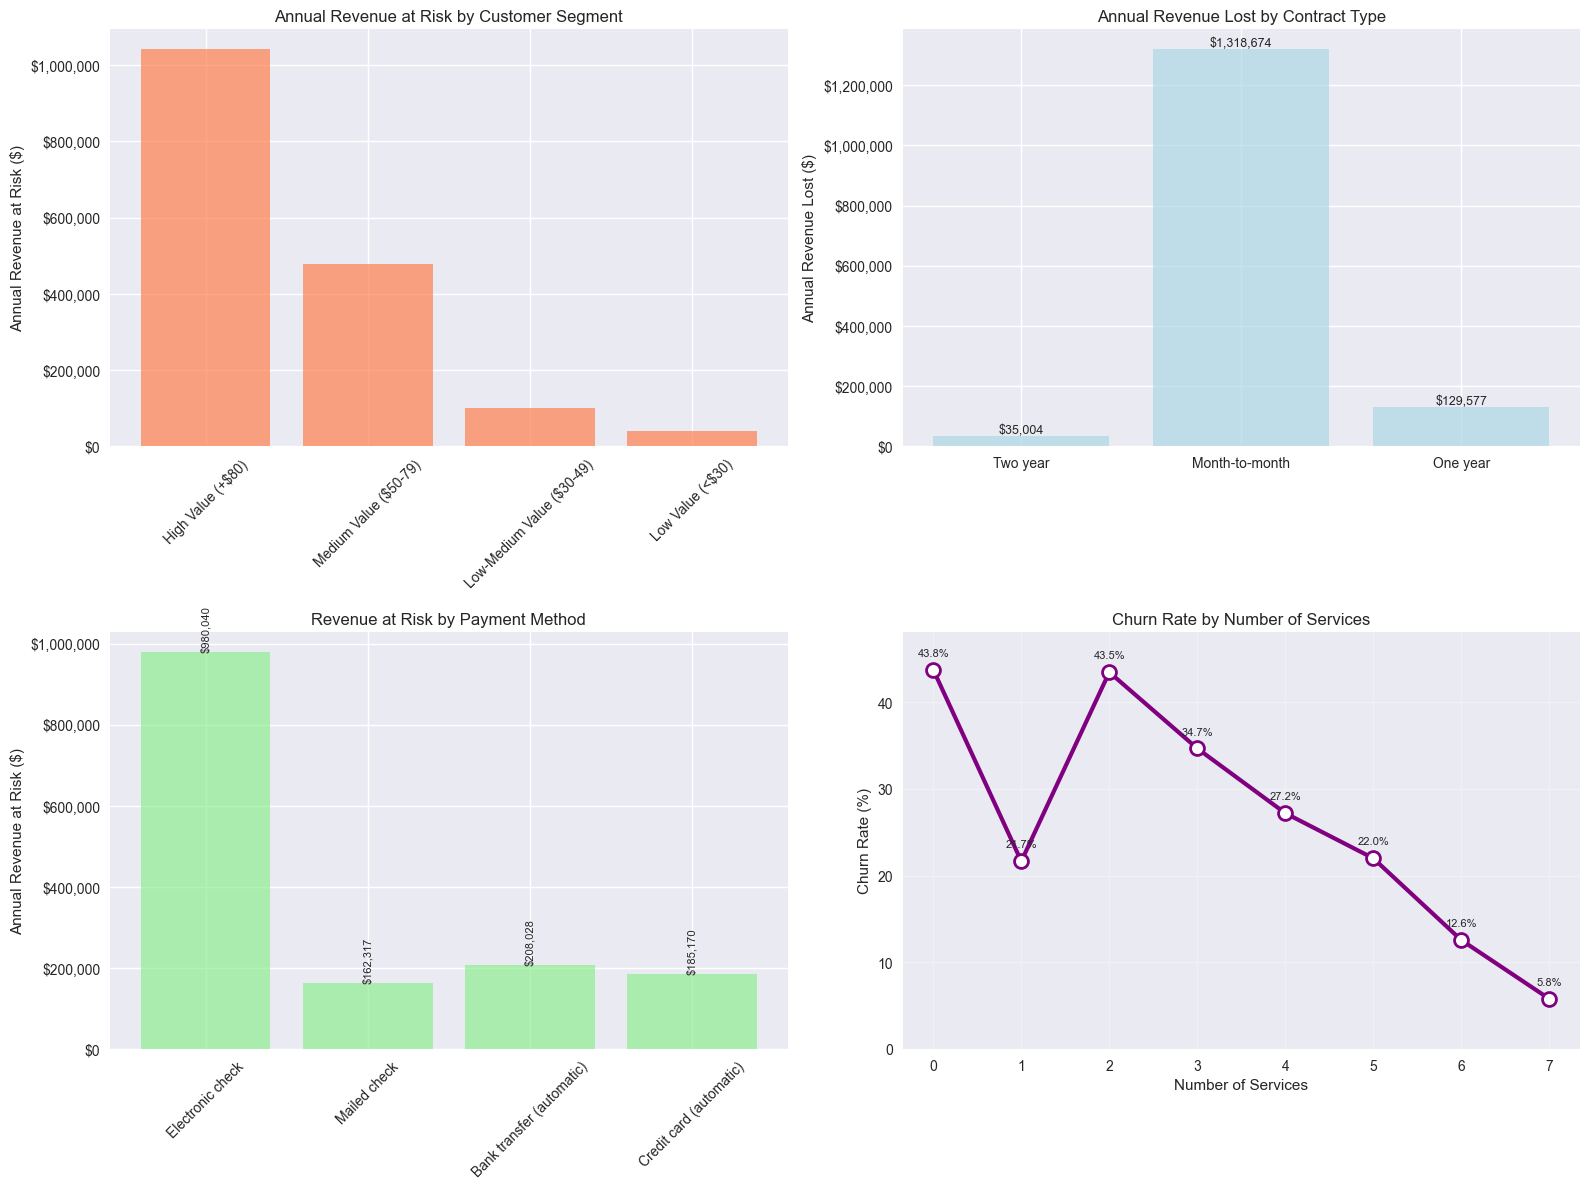

📊 Plot saved: financial_impact_analysis

<Figure size 1200x800 with 0 Axes>

In [37]:
# Cell: Financial Impact Visualization - Fixed
print("📊 CREATING FINANCIAL IMPACT VISUALIZATIONS")
print("=" * 50)

#
# Create the visualization with corrected column names
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Revenue at risk by customer segment
try:
    segment_data = segment_summary.to_pandas()
    
    # Check what the actual column name is for value segment
    value_col = None
    revenue_col = None
    
    for col in segment_data.columns:
        if 'segment' in col.lower() or 'value' in col.lower():
            value_col = col
        if 'revenue' in col.lower() and 'risk' in col.lower():
            revenue_col = col
    
    
    if value_col and revenue_col:
        ax1.bar(segment_data[value_col], segment_data[revenue_col], 
                color='coral', alpha=0.7)
        ax1.set_title('Annual Revenue at Risk by Customer Segment')
        ax1.set_ylabel('Annual Revenue at Risk ($)')
        ax1.tick_params(axis='x', rotation=45)
        
        # Format y-axis as currency
        ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    else:
        ax1.text(0.5, 0.5, 'Segment data not available', ha='center', va='center', transform=ax1.transAxes)
        ax1.set_title('Customer Segment Analysis')
        
except Exception as e:
    print(f"Error with segment plot: {e}")
    ax1.text(0.5, 0.5, f'Segment plot error:\n{str(e)[:50]}', ha='center', va='center', transform=ax1.transAxes)

# 2. Contract type revenue impact
try:
    contract_data = contract_summary.to_pandas()
    
    # Find the correct column names
    contract_col = 'Contract'
    revenue_col = None
    
    for col in contract_data.columns:
        if 'revenue' in col.lower() and ('lost' in col.lower() or 'risk' in col.lower()):
            revenue_col = col
            break
    
    print(f"Contract revenue column: {revenue_col}")
    
    if revenue_col:
        bars = ax2.bar(contract_data[contract_col], contract_data[revenue_col], 
                      color='lightblue', alpha=0.7)
        ax2.set_title('Annual Revenue Lost by Contract Type')
        ax2.set_ylabel('Annual Revenue Lost ($)')
        ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'${height:,.0f}', ha='center', va='bottom', fontsize=9)
    else:
        ax2.text(0.5, 0.5, 'Contract data not available', ha='center', va='center', transform=ax2.transAxes)
        
except Exception as e:
    print(f"Error with contract plot: {e}")
    ax2.text(0.5, 0.5, f'Contract plot error', ha='center', va='center', transform=ax2.transAxes)

# 3. Payment method risk
try:
    payment_data = payment_analysis.to_pandas()
    
    # Find correct column names
    payment_col = 'PaymentMethod'
    revenue_col = None
    
    for col in payment_data.columns:
        if 'revenue' in col.lower() and 'risk' in col.lower():
            revenue_col = col
            break
    
    print(f"Payment revenue column: {revenue_col}")
    
    if revenue_col:
        bars = ax3.bar(payment_data[payment_col], payment_data[revenue_col], 
                      color='lightgreen', alpha=0.7)
        ax3.set_title('Revenue at Risk by Payment Method')
        ax3.set_ylabel('Annual Revenue at Risk ($)')
        ax3.tick_params(axis='x', rotation=45)
        ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax3.text(bar.get_x() + bar.get_width()/2., height,
                        f'${height:,.0f}', ha='center', va='bottom', fontsize=8, rotation=90)
    else:
        ax3.text(0.5, 0.5, 'Payment data not available', ha='center', va='center', transform=ax3.transAxes)
        
except Exception as e:
    print(f"Error with payment plot: {e}")
    ax3.text(0.5, 0.5, f'Payment plot error', ha='center', va='center', transform=ax3.transAxes)

# 4. Service count vs churn rate
try:
    service_data = service_count_analysis.to_pandas()
    
    # Find correct column names
    services_col = 'total_services'
    churn_col = 'churn_rate'
    
    print(f"Service columns: {service_data.columns}")
    
    if services_col in service_data.columns and churn_col in service_data.columns:
        ax4.plot(service_data[services_col], service_data[churn_col], 
                marker='o', linewidth=3, markersize=10, color='purple', markerfacecolor='white', 
                markeredgecolor='purple', markeredgewidth=2)
        ax4.set_title('Churn Rate by Number of Services')
        ax4.set_xlabel('Number of Services')
        ax4.set_ylabel('Churn Rate (%)')
        ax4.grid(True, alpha=0.3)
        ax4.set_ylim(0, max(service_data[churn_col]) * 1.1)
        
        # Add value labels on points
        for i, (x, y) in enumerate(zip(service_data[services_col], service_data[churn_col])):
            ax4.annotate(f'{y:.1f}%', (x, y), textcoords="offset points", 
                        xytext=(0,10), ha='center', fontsize=8)
    else:
        ax4.text(0.5, 0.5, 'Service data not available', ha='center', va='center', transform=ax4.transAxes)
        
except Exception as e:
    print(f"Error with service plot: {e}")
    ax4.text(0.5, 0.5, f'Service plot error', ha='center', va='center', transform=ax4.transAxes)

plt.tight_layout()
plt.show()

# Save the plot (you'll need to implement this function)
try:
    # Create a simple save function if it doesn't exist
    from pathlib import Path
    from datetime import datetime
    
    def save_plot_for_report(fig, filename, title=""):
        """Save plots with consistent formatting for reports."""
        
        # Ensure figures directory exists
        figures_dir = Path("../outputs/figures")
        figures_dir.mkdir(parents=True, exist_ok=True)
        
        # Save with metadata
        if title:
            fig.suptitle(f"{title}\nGenerated: {datetime.now().strftime('%Y-%m-%d')}", y=0.98)
        
        # Save in multiple formats
        fig.savefig(figures_dir / f"{filename}.png", dpi=300, bbox_inches='tight')
        fig.savefig(figures_dir / f"{filename}.pdf", bbox_inches='tight')
        
        print(f"📊 Plot saved: {filename}")
    
    save_plot_for_report(plt.gcf(), "financial_impact_analysis", "Customer Churn Financial Impact Analysis")
    
except Exception as e:
    print(f"Note: Could not save plot - {e}")